## Libraries and Settings

In [1]:
# data manipulation
import numpy as np
import pandas as pd
import datetime
from scipy import stats
import PyPDF2
import os
import re

# data viz
from matplotlib import pyplot as plt
from matplotlib import rcParams
from matplotlib import ticker
import seaborn as sns
import matplotlib.dates as mdates


#warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Viz Styling
plt.style.use('default')
rcParams['figure.figsize'] = (12,  6)
pd.set_option('display.max_columns',50)


## Import Data

In [2]:
trips = pd.read_excel('data/RAW-2019-Chevy-Bolt-Trip-Data.xlsx')

trips.sort_values('Start Date').tail()


,Vehicle Model,Start Date,End Date,Duration,Distance (mi),Gasoline Consumed (gal),Electricity Consumed (kWh),Fuel Efficiency Equivalent (MPGeq),mi/kWh,Starting SOC (%),Ending SOC (%),Ambient Temperature (F),Smooth Acceleration (%),Smooth Braking (%)
1196,2019 Chevrolet Bolt EV,2022-11-29 07:59:27,2022-11-29 08:25:02,00:25:35,17.60,NaN,5.89,100.71,2.988115,100.00,89.80,35.67,NaN,NaN
1197,2019 Chevrolet Bolt EV,2022-11-29 15:38:54,2022-11-29 16:12:07,00:33:13,14.31,NaN,4.03,119.67,3.550868,89.80,83.92,39.10,NaN,NaN
1198,2019 Chevrolet Bolt EV,2022-11-29 18:09:27,2022-11-29 18:58:13,00:48:46,33.47,NaN,9.83,114.76,3.404883,83.92,67.06,35.00,NaN,NaN
1199,2019 Chevrolet Bolt EV,2022-11-30 08:17:23,2022-11-30 08:45:27,00:28:04,17.47,NaN,5.57,105.74,3.136445,100.00,90.58,41.45,NaN,NaN
1200,2019 Chevrolet Bolt EV,2022-11-30 20:28:37,2022-11-30 21:03:52,00:35:15,18.87,NaN,5.06,125.66,3.729249,90.58,82.35,45.73,NaN,NaN


In [3]:
# Finding null columns
np.sum(~trips.isnull())

Vehicle Model                         1201
Start Date                            1201
End Date                              1201
Duration                              1201
Distance (mi)                         1201
Gasoline Consumed (gal)                  0
Electricity Consumed (kWh)            1199
Fuel Efficiency Equivalent (MPGeq)    1110
mi/kWh                                1201
Starting SOC (%)                      1201
Ending SOC (%)                        1201
Ambient Temperature (F)               1011
Smooth Acceleration (%)                  0
Smooth Braking (%)                       0
dtype: int64

## Cleaning

In [4]:
# Removing Null Columns and irrelivant columns
trips.drop(labels = ['Vehicle Model', r'Gasoline Consumed (gal)'\
                     , r'Smooth Acceleration (%)', r'Smooth Braking (%)'], axis = 1, inplace = True)

In [5]:
# Removing 0.00 mile trips (i.e. I turned on the car for a minute, but didn't go anywhere)
trips = trips.loc[trips[r'Distance (mi)'] != 0 ,:]

# Removing negative electricity_consumed outliers.
trips = trips.loc[trips[r'Electricity Consumed (kWh)'] >= 0,:]


In [6]:
# converting SOC columns to decimal values (/100)
trips[r'Starting SOC (%)'] = trips[r'Starting SOC (%)']/100
trips[r'Ending SOC (%)'] = trips[r'Ending SOC (%)']/100

In [7]:
# Appending Columns to provide additional Analysis
# Projected Mile Range at Start and end of trip
# Using the formula (mi/kWh)*(SOC*battery size): battery size is 66kWh
battery_size = 66

trips['start_range'] = trips['mi/kWh']*(trips[r'Starting SOC (%)']*battery_size)
trips['end_range'] = trips['mi/kWh']*(trips[r'Ending SOC (%)']*battery_size)

In [8]:
trips.columns

Index(['Start Date', 'End Date', 'Duration', 'Distance (mi)',
       'Electricity Consumed (kWh)', 'Fuel Efficiency Equivalent (MPGeq)',
       'mi/kWh', 'Starting SOC (%)', 'Ending SOC (%)',
       'Ambient Temperature (F)', 'start_range', 'end_range'],
      dtype='object')

In [9]:
# Rename column names
trips = trips.rename(columns = {r'Start Date' : 'start_date',
           r'End Date' : 'end_date',
           r'Duration' : 'duration',
           r'Distance (mi)' : 'distance',
           r'Electricity Consumed (kWh)' : 'electricity_used',
           r'mi/kWh' : 'mikWh',
           r'Fuel Efficiency Equivalent (MPGeq)' : 'MPGe',
           r'Starting SOC (%)' : 'start_soc',
           r'Ending SOC (%)' : 'end_soc',
           r'Ambient Temperature (F)' : 'temp',
          }
         )

In [10]:
# trips['start_date'] = pd.to_datetime(trips['start_date']).dt.date
# trips['start_time'] = pd.to_datetime(trips['start_date']).dt.time
# trips['end_date'] = pd.to_datetime(trips['end_date']).dt.date
# trips['end_time'] = pd.to_datetime(trips['end_date']).dt.time

# trips

In [11]:
trips

,start_date,end_date,duration,distance,electricity_used,MPGe,mikWh,start_soc,end_soc,temp,start_range,end_range
0,2022-02-24 08:25:56,2022-02-24 09:32:13,01:06:17,45.54,12.64,121.44,3.602848,0.0000,0.0000,31.81,0.000000,0.000000
3,2022-02-24 18:00:42,2022-02-24 19:06:38,01:05:56,45.57,13.19,116.46,3.454890,0.5608,0.3216,36.96,127.875155,73.332115
4,2022-02-26 09:50:22,2022-02-26 10:03:52,00:13:30,5.36,1.67,108.13,3.209581,0.7726,0.7451,30.52,163.661662,157.836273
5,2022-02-26 10:04:49,2022-02-26 10:12:17,00:07:28,3.34,0.97,116.10,3.443299,0.7451,0.7294,28.45,169.329736,165.761790
6,2022-02-26 10:28:40,2022-02-26 10:31:18,00:02:38,0.45,0.18,84.94,2.500000,0.7294,0.7216,28.40,120.351000,119.064000
...,...,...,...,...,...,...,...,...,...,...,...,...
1196,2022-11-29 07:59:27,2022-11-29 08:25:02,00:25:35,17.60,5.89,100.71,2.988115,1.0000,0.8980,35.67,197.215620,177.099626
1197,2022-11-29 15:38:54,2022-11-29 16:12:07,00:33:13,14.31,4.03,119.67,3.550868,0.8980,0.8392,39.10,210.452873,196.672663
1198,2022-11-29 18:09:27,2022-11-29 18:58:13,00:48:46,33.47,9.83,114.76,3.404883,0.8392,0.6706,35.00,188.586936,150.698760
1199,2022-11-30 08:17:23,2022-11-30 08:45:27,00:28:04,17.47,5.57,105.74,3.136445,1.0000,0.9058,41.45,207.005386,187.505479


## Handling Missing Data

In [12]:
# Finding missing data
np.sum(~trips.isnull())

start_date          1092
end_date            1092
duration            1092
distance            1092
electricity_used    1092
MPGe                1092
mikWh               1092
start_soc           1092
end_soc             1092
temp                 924
start_range         1092
end_range           1092
dtype: int64

## Temperature NaN Values

There does not seem to be a pattern regarding the missing temperature data. 

There are 168 temperature data points missing, out of a total of 1092 data points. 

***13%*** of the temperature data points are missing. I have chosen to interpolate the missing data with a linear model. 

In [13]:
trips[trips.temp.isnull()].sort_values('start_date')#.describe()

,start_date,end_date,duration,distance,electricity_used,MPGe,mikWh,start_soc,end_soc,temp,start_range,end_range
33,2022-03-05 15:51:54,2022-03-05 15:59:33,00:07:39,1.62,0.69,79.34,2.347826,0.7647,0.7568,NaN,118.495252,117.271096
51,2022-03-09 17:18:45,2022-03-09 17:20:06,00:01:21,0.12,0.03,136.13,4.000000,0.7058,0.7098,NaN,186.331200,187.387200
58,2022-03-11 00:54:56,2022-03-11 00:55:33,00:00:37,0.04,0.01,148.70,4.000000,0.3020,0.3020,NaN,79.728000,79.728000
62,2022-03-12 07:59:54,2022-03-12 08:01:07,00:01:13,0.01,0.01,20.94,1.000000,0.4824,0.5333,NaN,31.838400,35.197800
97,2022-03-19 16:05:20,2022-03-19 16:09:49,00:04:29,0.72,0.16,150.92,4.500000,0.5804,0.6000,NaN,172.378800,178.200000
...,...,...,...,...,...,...,...,...,...,...,...,...
1162,2022-11-19 15:25:29,2022-11-19 16:10:34,00:45:05,23.87,6.63,121.36,3.600302,0.8118,0.6941,NaN,192.899843,164.931979
1170,2022-11-22 12:44:33,2022-11-22 12:49:55,00:05:22,1.60,0.06,899.52,26.666667,0.9137,0.9137,NaN,1608.112000,1608.112000
1180,2022-11-25 08:21:56,2022-11-25 09:07:08,00:45:12,35.56,10.62,112.87,3.348399,0.5098,0.3255,NaN,112.662920,71.933661
1189,2022-11-27 13:47:42,2022-11-27 13:49:15,00:01:33,0.24,0.07,115.19,3.428571,0.9882,0.9882,NaN,223.615543,223.615543


In [14]:
# SORT by date then Interpolate Missing data points based on recent days
trips['temp'] = trips.sort_values('start_date').temp.interpolate(method = 'linear')

# new 'temp' column missing data points
np.sum(trips['temp'].isnull()) # 0

0

## Write clean data to .csv

In [15]:
trips.to_csv('data/CLEAN-2019-Chevy-Bolt-Trip-Data.csv', sep=',', encoding='utf-8')

## Data Summary

In [16]:
trips.describe()

,distance,electricity_used,MPGe,mikWh,start_soc,end_soc,temp,start_range,end_range
count,1092.000000,1092.000000,1092.000000,1092.000000,1092.000000,1092.000000,1092.000000,1092.000000,1092.000000
mean,15.934625,3.893306,152.240824,4.515056,0.726474,0.663368,65.677898,216.435830,199.327548
std,23.537214,5.667625,184.777458,5.470657,0.161817,0.184336,15.691951,275.939166,277.616239
min,0.010000,0.000000,0.000000,0.000000,0.000000,0.000000,23.420000,0.000000,0.000000
25%,1.707500,0.390000,107.897500,3.201098,0.653925,0.567625,53.570000,139.373270,117.428309
50%,5.290000,1.215000,132.995000,3.946428,0.749000,0.690200,67.725000,189.269131,168.324154
75%,18.500000,5.230000,165.630000,4.913897,0.815600,0.764700,78.800000,250.614535,231.463846
max,177.480000,42.320000,5374.050000,159.000000,1.000000,1.000000,99.540000,7983.835200,7983.835200


In [17]:
trips[trips.distance>18].corr().temp.mikWh

0.5628122399055951

In [18]:
trips.electricity_used.sum()


4251.490000000001

In [19]:
trips.electricity_used.sum()/4

1062.8725000000002

In [20]:
trips.distance.sum()

17400.61

## Does Distance have an Effect on Effeciency?

In [21]:
# Quick Look at counts at different distances
short_trips = trips.loc[trips.distance<3.3]
med_trips = trips.loc[(trips.distance>=3.3) & (trips.distance<18)]
long_trips = trips.loc[trips.distance>=18]
print(short_trips.distance.count())
print(med_trips.distance.count())
print(long_trips.distance.count())

419
394
279


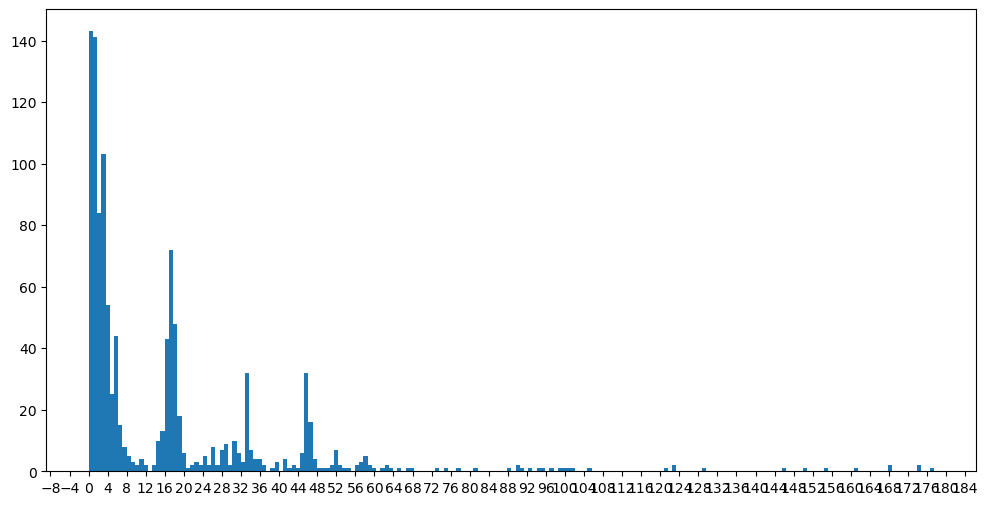

In [22]:
fig, ax = plt.subplots()
ax.hist(trips.distance, bins = 200)
ax.xaxis.set_major_locator(ticker.MultipleLocator(4));

In [23]:
# creating quick function to append column with a category for how long the trip was
def distance_describer(x):
    if x['distance'] < 3.3:
        return 'Short Trip'
    if (x['distance'] >= 3.3) & (x['distance'] <18):
        return 'Medium Trip'
    if x['distance'] >= 18:
        return 'Long Trip'

In [24]:
#appending Column to Dataframe describing if the trip was short, medium, or long
trips['distance_desc'] = trips.apply(lambda x: distance_describer(x), axis = 1)
trips

,start_date,end_date,duration,distance,electricity_used,MPGe,mikWh,start_soc,end_soc,temp,start_range,end_range,distance_desc
0,2022-02-24 08:25:56,2022-02-24 09:32:13,01:06:17,45.54,12.64,121.44,3.602848,0.0000,0.0000,31.81,0.000000,0.000000,Long Trip
3,2022-02-24 18:00:42,2022-02-24 19:06:38,01:05:56,45.57,13.19,116.46,3.454890,0.5608,0.3216,36.96,127.875155,73.332115,Long Trip
4,2022-02-26 09:50:22,2022-02-26 10:03:52,00:13:30,5.36,1.67,108.13,3.209581,0.7726,0.7451,30.52,163.661662,157.836273,Medium Trip
5,2022-02-26 10:04:49,2022-02-26 10:12:17,00:07:28,3.34,0.97,116.10,3.443299,0.7451,0.7294,28.45,169.329736,165.761790,Medium Trip
6,2022-02-26 10:28:40,2022-02-26 10:31:18,00:02:38,0.45,0.18,84.94,2.500000,0.7294,0.7216,28.40,120.351000,119.064000,Short Trip
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1196,2022-11-29 07:59:27,2022-11-29 08:25:02,00:25:35,17.60,5.89,100.71,2.988115,1.0000,0.8980,35.67,197.215620,177.099626,Medium Trip
1197,2022-11-29 15:38:54,2022-11-29 16:12:07,00:33:13,14.31,4.03,119.67,3.550868,0.8980,0.8392,39.10,210.452873,196.672663,Medium Trip
1198,2022-11-29 18:09:27,2022-11-29 18:58:13,00:48:46,33.47,9.83,114.76,3.404883,0.8392,0.6706,35.00,188.586936,150.698760,Long Trip
1199,2022-11-30 08:17:23,2022-11-30 08:45:27,00:28:04,17.47,5.57,105.74,3.136445,1.0000,0.9058,41.45,207.005386,187.505479,Medium Trip


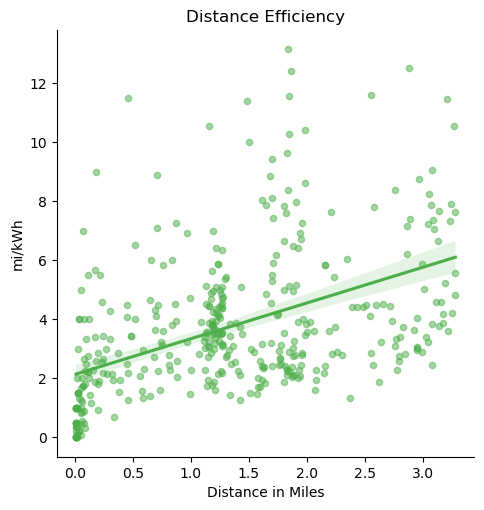

In [25]:
blue = '#377eb8'
orange = '#ff7f00'
green = '#4daf4a'
pink = '#f781bf'
brown = '#a65628'
purple = '#984ea3'
grey = '#999999'
red = '#e41a1c'
yellow = '#dede00'

g = sns.lmplot(x='distance', y='mikWh',\
               data=trips[(trips.mikWh<15)&(trips.distance_desc == 'Short Trip')],\
               hue='distance_desc',\
               palette = [green,blue,red], scatter_kws={"s": 20, "alpha":.5})
g._legend.remove()
plt.title('Distance Efficiency')
plt.xlabel('Distance in Miles')
plt.ylabel('mi/kWh')
plt.savefig("images/distance_eff_1",bbox_inches='tight');

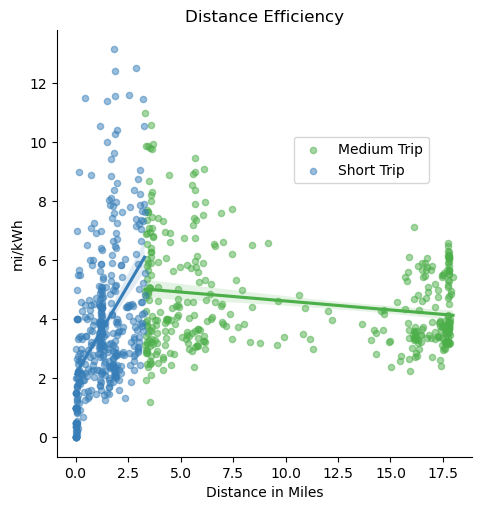

In [26]:
blue = '#377eb8'
orange = '#ff7f00'
green = '#4daf4a'
pink = '#f781bf'
brown = '#a65628'
purple = '#984ea3'
grey = '#999999'
red = '#e41a1c'
yellow = '#dede00'

g = sns.lmplot(x='distance', y='mikWh',\
           data=trips[(trips.mikWh<15)&(trips.distance_desc == 'Short Trip')|(trips.distance_desc == 'Medium Trip')], hue='distance_desc',\
           palette = [green,blue,red], scatter_kws={"s": 20, "alpha":.5})
g._legend.remove()
plt.legend(title='',bbox_to_anchor=(0.57, .75), loc='upper left', borderaxespad=0)
plt.title('Distance Efficiency')
plt.xlabel('Distance in Miles')
plt.ylabel('mi/kWh')
plt.savefig("images/distance_eff_2",bbox_inches='tight');



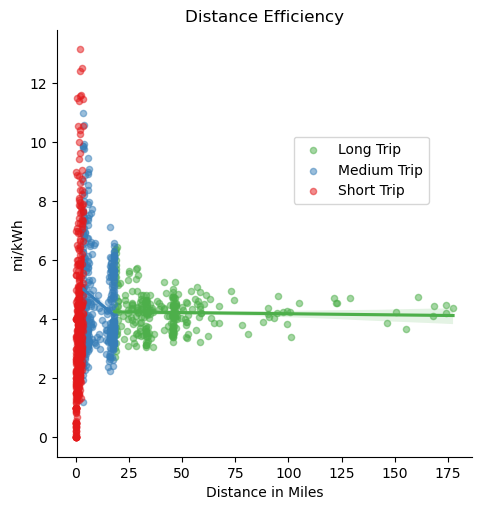

In [27]:
blue = '#377eb8'
orange = '#ff7f00'
green = '#4daf4a'
pink = '#f781bf'
brown = '#a65628'
purple = '#984ea3'
grey = '#999999'
red = '#e41a1c'
yellow = '#dede00'

g = sns.lmplot(x='distance', y='mikWh',\
           data=trips[(trips.mikWh<15)&((trips.distance_desc == 'Short Trip')|(trips.distance_desc == 'Long Trip')|(trips.distance_desc == 'Medium Trip'))],\
           hue='distance_desc',\
           palette = [green,blue,red], scatter_kws={"s": 20, "alpha":.5})

g._legend.remove()
plt.legend(title='',bbox_to_anchor=(0.57, .75), loc='upper left', borderaxespad=0)
plt.title('Distance Efficiency')
plt.xlabel('Distance in Miles')
plt.ylabel('mi/kWh')
plt.savefig("images/distance_eff_3", bbox_inches='tight');

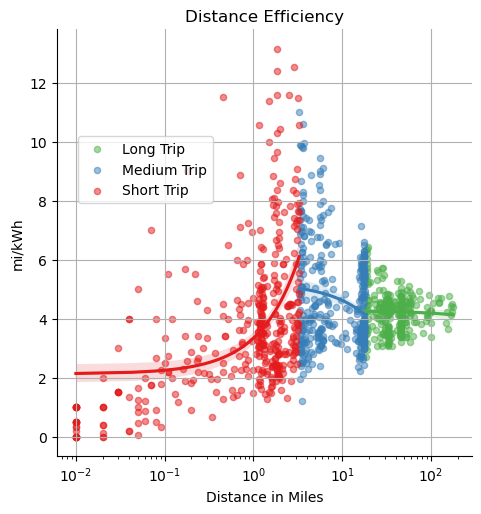

In [43]:
blue = '#377eb8'
orange = '#ff7f00'
green = '#4daf4a'
pink = '#f781bf'
brown = '#a65628'
purple = '#984ea3'
grey = '#999999'
red = '#e41a1c'
yellow = '#dede00'

def mi_format(x, pos):
    return '{:3.0f} mi'.format(x)



g = sns.lmplot(x='distance', y='mikWh', data=trips[trips.mikWh<15],\
               hue='distance_desc', palette = [green,blue,red], scatter_kws={"s": 20, "alpha":.5})
g.set(xscale="log") 
plt.grid(which='major')
g._legend.remove()

# labeling


# g.set_xticklabels(mi_format)


plt.legend(title='',bbox_to_anchor=(0.05, .75), loc='upper left', borderaxespad=0)
plt.title('Distance Efficiency')
plt.xlabel('Distance in Miles')
ax.get_xaxis().set_major_formatter(ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

plt.ylabel('mi/kWh')


# plt.ticklabel_format(style='plain', axis='x',useOffset=False)
plt.savefig("images/distance_eff_4", bbox_inches='tight');

## Does time of day have an Effect on Effeciency?

In [ ]:
def time_describe(x):
    if (x >= 0) and (x < 6):
        return 'Wee Hours'
    elif (x >= 6) and (x < 12):
        return 'Morning'
    elif (x >= 12) and (x <= 18):
        return'Afternoon'
    elif (x >= 16) and (x < 24) :
        return 'Night'

In [ ]:
trips['time_desc'] = trips.start_date.dt.hour.apply(time_describe)
trips

In [ ]:
# Average efficiency by time of day
time_group = trips.groupby('time_desc')
time_group.mikWh.mean()

In [ ]:
# Count of trips by time of day

time_group.start_date.count()

In [ ]:
blue = '#377eb8'
orange = '#ff7f00'
green = '#4daf4a'
pink = '#f781bf'
brown = '#a65628'
purple = '#984ea3'
grey = '#999999'
red = '#e41a1c'
yellow = '#dede00'

# fig, ax = plt.subplots()

y = trips.mikWh
x = trips.time_desc


g = sns.boxplot(x=x, y=y, palette = [orange,blue,green,red], data=trips, showfliers = False, order = ['Wee Hours','Morning','Afternoon','Night'])

plt.title('Time of Day vs Efficiency')
plt.xlabel('')
g.spines['bottom'].set_visible(True)
g.spines['left'].set_visible(True)
g.spines['right'].set_visible(False)
g.spines['top'].set_visible(False)
plt.savefig("images/time_eff", bbox_inches='tight');

# The shape exapands as the traffic conditions worsen.

# Column Analysis

## Skewness and Kurtosis

<img src="images/skewness.png" width="500" align = "left"/>

<img src="images/kurtosis.jpg" width="400" align = "left"/>

In [ ]:
# Skewness: asymmetry from the norm
print(f"Skewness: {trips[r'temp'].skew()}")
print(f"Kurtosis: {trips[r'temp'].kurt()}")

In [ ]:
trips

In [ ]:
trips_facet = trips.iloc[:,3:12]

f, axes = plt.subplots(3, 3, figsize=(10, 10), sharex=False)
sns.distplot(trips_facet.distance, ax=axes[0,0])
sns.distplot(trips_facet.electricity_used, ax=axes[0,1])
sns.distplot(trips_facet.MPGe, ax=axes[0,2])
sns.distplot(trips_facet.mikWh, ax=axes[1,0])
sns.distplot(trips_facet.start_soc, ax=axes[1,1])
sns.distplot(trips_facet.end_soc, ax=axes[1,2])
sns.distplot(trips_facet.temp, ax=axes[2,0])
sns.distplot(trips_facet.start_range, ax=axes[2,1])
sns.distplot(trips_facet.end_range, ax=axes[2,2])

for i, ax in enumerate(axes.reshape(-1)):
    ax.text(x=0.97, y=0.97, transform=ax.transAxes, s="Skewness: %f" % trips_facet.iloc[:,i].skew(),\
        fontweight='demibold', fontsize=7, verticalalignment='top', horizontalalignment='right',\
        backgroundcolor='white', color='xkcd:poo brown')
    ax.text(x=0.97, y=0.91, transform=ax.transAxes, s="Kurtosis: %f" % trips_facet.iloc[:,i].kurt(),\
        fontweight='demibold', fontsize=7, verticalalignment='top', horizontalalignment='right',\
        backgroundcolor='white', color='xkcd:dried blood')
    ax.text(x=0.97, y=0.85, transform=ax.transAxes, s="Mean: %f" % trips_facet.iloc[:,i].mean(),\
        fontweight='demibold', fontsize=7, verticalalignment='top', horizontalalignment='right',\
        backgroundcolor='white', color='teal')
plt.tight_layout();



-------------------------------------

The data has a total of ***1092*** observations.

This data takes place in the <u>**temp range 23-100&deg;F**</u>

In [ ]:
print(trips.temp.min())
print(trips.temp.max())

## Trips by day

In [ ]:
# creating a dataframe to summarize information by day
trips_by_day = trips.groupby([trips['start_date'].dt.date]).sum()
trips_by_day

In [ ]:
trips_by_day.distance.mean()

In [ ]:
trips_by_day.distance.max()

## distance 
Avg trip <u>**distance**</u> is 15.9 mi

In [ ]:
trips.distance.max()

In [ ]:
trips.distance.mean()

I've taken 38 trips over 60 mi. 

In [ ]:
trips.distance[trips.distance > 90].count()

In [ ]:
date1 = pd.to_datetime('2/24/22')
date2 = pd.to_datetime('12/17/22')
total_trips_days = date2-date1 # 296 days
trips_per_day = 1092/296
trips_per_day

In [ ]:
trips.distance.sum()

In [ ]:
trips[trips.end_soc <.05]

In [ ]:


facecolor = 'white'
color_bars = '#377eb8'
txt_color1 = 'k'
txt_color2 = 'k'
fig, ax = plt.subplots(1, figsize=(20,6), facecolor=facecolor)
ax.set_facecolor(facecolor)
n, bins, patches = plt.hist(trips.distance, color=color_bars, bins='doane')

#grid

plt.grid(which='minor', color=facecolor, lw = 0.5)
xticks = [(bins[idx+1] + value)/2 for idx, value in enumerate(bins[:-1])]
xticks_labels = [ "{:.0f}-{:.0f}".format(value, bins[idx+1]) for idx, value in enumerate(bins[:-1])]
plt.xticks(xticks, labels=xticks_labels, c=txt_color1, fontsize=13)

# remove major and minor ticks from the x axis, but keep the labels
ax.tick_params(axis='x', which='both',length=0)

# remove y ticks
plt.yticks([])

# Hide the right and top spines
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
for idx, value in enumerate(n):
    if value > 0:
        plt.text(xticks[idx], value+5, int(value), ha='center', fontsize=16, c=txt_color1)
plt.title('Miles Driven\n', fontsize = 30, c=txt_color1)
plt.xlabel('\nMiles', c=txt_color2, fontsize=20)
plt.ylabel('Trip Count', c=txt_color2, fontsize=20)
plt.tight_layout()
plt.savefig("images/distance_histogram",bbox_inches='tight')

### Short trips < 3.3 mi
The distance series is very skewed  to the left (3.19) toward shorter trips. 

Because the data is skewed so much that way, I want to take a look at these shorter trips and see if they are properly distributed and verify the quality of the data.  

In [ ]:
fig, ax = plt.subplots()
x = short_trips.distance
sns.distplot(x)


ax.text(x=0.97, y=0.97, transform=ax.transAxes, s="Skewness: %f" % x.skew(),\
    fontweight='demibold', fontsize=7, verticalalignment='top', horizontalalignment='right',\
    backgroundcolor='white', color='xkcd:poo brown')
ax.text(x=0.97, y=0.91, transform=ax.transAxes, s="Kurtosis: %f" % x.kurt(),\
    fontweight='demibold', fontsize=7, verticalalignment='top', horizontalalignment='right',\
    backgroundcolor='white', color='xkcd:dried blood')
ax.text(x=0.97, y=0.85, transform=ax.transAxes, s="Mean: %f" % x.mean(),\
    fontweight='demibold', fontsize=7, verticalalignment='top', horizontalalignment='right',\
    backgroundcolor='white', color='teal')
plt.tight_layout()
;


In [ ]:
### Medium trips

In [ ]:
fig, ax = plt.subplots()
x = trips[trips.distance_desc == 'Medium Trip'].distance
sns.distplot(x)


ax.text(x=0.97, y=0.97, transform=ax.transAxes, s="Skewness: %f" % x.skew(),\
    fontweight='demibold', fontsize=7, verticalalignment='top', horizontalalignment='right',\
    backgroundcolor='white', color='xkcd:poo brown')
ax.text(x=0.97, y=0.91, transform=ax.transAxes, s="Kurtosis: %f" % x.kurt(),\
    fontweight='demibold', fontsize=7, verticalalignment='top', horizontalalignment='right',\
    backgroundcolor='white', color='xkcd:dried blood')
ax.text(x=0.97, y=0.85, transform=ax.transAxes, s="Mean: %f" % x.mean(),\
    fontweight='demibold', fontsize=7, verticalalignment='top', horizontalalignment='right',\
    backgroundcolor='white', color='teal')
plt.tight_layout();

In [ ]:
### Long Trips

In [ ]:
fig, ax = plt.subplots()
x = x = trips[trips.distance_desc == 'Long Trip'].distance
sns.distplot(x)


ax.text(x=0.97, y=0.97, transform=ax.transAxes, s="Skewness: %f" % x.skew(),\
    fontweight='demibold', fontsize=7, verticalalignment='top', horizontalalignment='right',\
    backgroundcolor='white', color='xkcd:poo brown')
ax.text(x=0.97, y=0.91, transform=ax.transAxes, s="Kurtosis: %f" % x.kurt(),\
    fontweight='demibold', fontsize=7, verticalalignment='top', horizontalalignment='right',\
    backgroundcolor='white', color='xkcd:dried blood')
ax.text(x=0.97, y=0.85, transform=ax.transAxes, s="Mean: %f" % x.mean(),\
    fontweight='demibold', fontsize=7, verticalalignment='top', horizontalalignment='right',\
    backgroundcolor='white', color='teal')
plt.tight_layout();

## electricity_used

An average trip uses <u>**3.89 kWh of energy**</u>.

This represents <u>**5.9%**</u> of the 66kWh Battery's capacity. 

This means if the battery is charged to 100%, on average a Chevy Bolt owner could get <u>**16 trips out of single charge.**</u> 

However, This is unrealistic because you shouldn't start a trip with less than 10%. In my dataset I started a trip with less than 10% <u>**2 times**</u> and ended a trip with less than 10% <u>**7 times**</u>. You also shouldn't really charge past 80% of the capcity. I did this <u>**305 times**</u>. ...Whoops.

So following all the best practices you are looking at an AVG of 11 trips of 15.5mi(3.88 kWh) each per responsible Charge. 

In [ ]:
print(trips.electricity_used.mean()/66)
print(66//trips.electricity_used.mean())
print((66*.7)//trips.electricity_used.mean())
print(trips.loc[trips['start_soc']<.10,'distance'].count()) # amount of times I started a trip with less than 10%
print(trips.loc[trips['end_soc']<.10,'distance'].count()) # amount of times I ended a trip with less than 10%
print(trips.loc[trips['start_soc']>.80,'distance'].count()) # amount of times I started a trip with more than 80%

11 trips, averaging 15 miles each sounds suffecient to me, but there are consumers that feel this isn't enough. And rightly fully so, considering that the US Federal Highway Administration shows that the average daily miles driven is ***36.9 miles*** * meaning that you could expect to get roughly two days out of the Chevy Bolt before you need to chargeup.

*https://www.fhwa.dot.gov/ohim/onh00/bar8.htm



In [ ]:
13476/365
(66*.7)/36.9

However, the interesting thing that most consumer's do not understand, is that the biggest benefit to an electric vehicle is that you have a "Gas Station" in your own home. Every day you come home, you can plug in your vehicle and it's back to full by the next day.

This completely changes way drivers think about the chore of "re-fueling".I RARELY have to go out of my way to refuel this past year. 

Most drivers visit the gas station 2-4 amount of times a month.

I have visited a charging station 12 times this year to charge out of neccesity outside of my garage.  

Average starting <u>**State of Charge(SOC):**</u> is ***70%***, meaning I have followed good charging practices for the health of the battery and that the data is more realistic/representative towards reccomended best practices, and not idealistic numbers. 

In [ ]:
trips.start_soc.mean()

In [ ]:
trips.end_soc.mean()

****Calculating MPGe****

In order to make any comparisions to gas vehicles we need some sort of conversion. The USA Environmental Protection Agency (EPA) has come up with a converstion to compare MPG to mi/kWh. It is called MPGe or "Miles per gallon equivalent"

Without getting too much in the weeds, the basis behind the conversion is that both burning gasoline and using electricity generates heat. so MPGe is essentially the heat equivalent of MPG. 

1 gallon of gas = 115,000 BTUs = 33.7kWh

<u> The avg MPGe for my trip data is 149.5 </u>

In [ ]:
trips.MPGe.mean()

and an avg <u>trip effeciency: 4.49 mi/kWh</u>

In [ ]:
trips.mikWh.mean()

# What do I do with Extreme mikWh values?
it's messing up the visuals and data?


In [ ]:
trips.sort_values('MPGe', ascending = False)

In [ ]:
# electricity_used
x = trips['start_date']
y = trips['electricity_used']
plt.hist(y, bins = 20);


In [ ]:
# MPGe
y = trips['MPGe']

plt.hist(y,bins=10);

In [ ]:
# mikWh
y = trips['mikWh']
plt.hist(y,bins=40);

In [ ]:
# start_soc
y = trips['start_soc']
plt.hist(y,bins=25);

In [ ]:
# end_soc
y = trips['end_soc']
plt.hist(y,bins=25);

In [ ]:
y1 = trips.start_soc
y2 = trips.end_soc
plt.hist(y1, alpha = .5, bins=20, color = 'blue')
plt.hist(y2, alpha = .5, bins=20, color = 'orange');

In [ ]:
my_fmt = mdates.DateFormatter('%m')

def fahr_format(x, pos):
    """The two arguments are the value and tick position."""
    return '{:3.0f}°F'.format(x)


x = trips['start_date']
y = trips['temp']

fig, ax = plt.subplots()
ax.scatter(x,y,c = trips.loc[:,'temp'], cmap = 'coolwarm')

ax.set_title('Climate Range')

ax.xaxis.set_major_formatter(
    mdates.ConciseDateFormatter(ax.xaxis.get_major_locator()))
ax.yaxis.set_major_formatter(fahr_format)
# ax.ticklabel_format(axis='y',) FormatStrFormatter('%°f')

# ax.set_yticklabels(['{:,\d}'.format(x) for x in ax])


In [ ]:
# temp
# my_fmt = mdates.DateFormatter('%d')
# months = mdates.MonthLocator()  # every month

x = trips['start_date']
y = trips['temp']
plt.scatter(x,y, c = trips.loc[:,'temp'], cmap = 'coolwarm')
plt.title("Driving Conditions")

# ax.xaxis.set_major_formatter(my_fmt);

## Range

MOST range with at least 80% battery was ***390 mi***

In [ ]:
trips[trips.distance >18].start_range.max()


LEAST range with at least 80% battery was ***185 mi***

In [ ]:
trips[(trips.distance >18) & (trips.start_range > 0) & (trips.start_soc > .8)].start_range.min()

In [ ]:
y1 = trips[trips.distance > 18].start_range

plt.hist(y1,bins=20);

In [ ]:
# end_range
y2 = trips[trips.distance > 18].end_range 
plt.hist(y2,bins=20);

In [ ]:
# BOTH ranges overlayed
y1 = trips[trips.distance > 18].start_range
y2 = trips[trips.distance > 18].end_range
plt.hist(y1, alpha = .5, bins=20)
plt.hist(y2, alpha = .5, bins=20);

In [ ]:
trips[trips[r'mikWh']<15]

In [ ]:
# temp = trips[trips[r'mi/kWh']<15]
# x = temp[r'mi/kWh']
# y = temp[r'Ambient Temperature (F)']
# a, b = np.polyfit(x, y, 1)

In [ ]:
sns.lmplot(y = r'mikWh', x = r'temp', data = trips)


In [ ]:
def fahr_format(x, pos):
    """The two arguments are the value and tick position."""
    return '{:3.0f}°F'.format(x)

# values
x = trips[trips[r'mikWh']<10].mikWh
y = trips[trips[r'mikWh']<10].temp

# plotting
fig, ax = plt.subplots()

ax.scatter(x=x, y=y,\
        c = trips.loc[trips[r'mikWh']<10,:][r'temp'],\
        cmap = 'coolwarm', alpha = 1)



# Labelling 
ax.set_title('Battery Effeciency')
ax.set_xlabel('mikWh')
ax.yaxis.set_major_formatter(fahr_format);



# sns.lmplot(x = r'mikWh', y = r'temp', data = temp)
# sns.jointplot(x = r'mikWh', y = r'temp', data = temp);
# temp.plot(x, a*x+b) 


# # Fit linear regression via least squares with numpy.polyfit
# # It returns an slope (b) and intercept (a)
# # deg=1 means linear fit (i.e. polynomial of degree 1)
# b, a = np.polyfit(x, y, deg=1)

# # Create sequence of 100 numbers from 0 to 100 
# xseq = np.linspace(0, 10, num=100)

# # Plot regression line
# ax.plot(xseq, a + b * xseq, color="k", lw=2.5);


In [ ]:
def fahr_format(x, pos):
    return '{:3.0f}°F'.format(x)

# values
x = trips[trips[r'mikWh']<10].mikWh
y = trips[trips[r'mikWh']<10].temp

# plotting
fig, ax = plt.subplots()

ax.scatter(x=x, y=y,\
        c = trips.loc[trips[r'mikWh']<10,:][r'temp'],\
        cmap = 'coolwarm', alpha = 1)

# Linear Regression Line
b, a = np.polyfit(x, y, deg=1)
xseq = np.linspace(0, 10, num=100)
ax.plot(xseq, a + b * xseq, color="grey", lw=1, linestyle = '--', alpha = .7)

# Labelling 
ax.set_title('Battery Effeciency')
ax.set_xlabel('mikWh')
ax.yaxis.set_major_formatter(fahr_format);

temp_cor = trips[trips.distance>18].corr().temp.mikWh
t = ax.text(x=0.88, y=0.675, transform=ax.transAxes, s = f"Correlation: {temp_cor:.1%}",\
    fontweight='demibold', fontsize=7, verticalalignment='top', horizontalalignment='right',\
    backgroundcolor='white', color='Grey', rotation=5.2)

t.set_bbox(dict(facecolor='white', alpha=0, linewidth=0));

### Summer vs. Winter performance

In [ ]:
# 40f and under
cold_avg = trips[(trips.distance>18)&(trips.temp<40)].mikWh.mean()
cold_range = cold_avg*66
print('cold avg:', f'{cold_avg:.2f}')
print('cold range:', f'{cold_range:.2f}')

print('-'*30)
# between 40-70
norm_avg = trips[(trips.distance>18)&((trips.temp>=40)|(trips.temp<=70))].mikWh.mean()
norm_range = norm_avg*66
print('norm avg:', f'{norm_avg:.2f}')
print('norm range:', f'{norm_range:.2f}')

print('-'*30)
# 70f and above
warm_avg = trips[(trips.distance>18)&(trips.temp>70)].mikWh.mean()
warm_range = warm_avg*66
print('warm avg:', f'{warm_avg:.2f}')
print('warm range:', f'{warm_range:.2f}')

In [ ]:
(warm_range - cold_range)/cold_range

In [ ]:
# creating quick function to append column with a category for how the temperature feels
def temp_describer(x):
    if x['temp'] < 40:
        return 'Cold'
    if (x['temp'] >= 40) & (x['temp'] <70):
        return 'Normal'
    if x['temp'] >= 70:
        return 'Hot'

In [ ]:
trips['temp_desc'] = trips.apply(lambda x: temp_describer(x), axis = 1)


In [ ]:
blue = '#377eb8'
orange = '#ff7f00'
green = '#4daf4a'
pink = '#f781bf'
brown = '#a65628'
purple = '#984ea3'
grey = '#999999'
red = '#e41a1c'
yellow = '#dede00'

sns.lmplot(y='temp', x='mikWh',\
               data=trips[(trips[r'mikWh']<10)], scatter_kws={"s": 20, "alpha":.5, 'color':blue})

plt.title('Temperature Efficiency')
plt.xlabel('mi/kWh')
plt.ylabel('Temperature')
plt.savefig("images/temp_lmplot",bbox_inches='tight');

In [ ]:
def fahr_format(x, pos):
    return '{:3.0f}°F'.format(x)

# values
x = trips[(trips[r'mikWh']<10)&(trips['temp']<40)].mikWh
y = trips[(trips[r'mikWh']<10)&(trips['temp']<40)].temp
blue = '#377eb8'
orange = '#ff7f00'
green = '#4daf4a'
pink = '#f781bf'
brown = '#a65628'
purple = '#984ea3'
grey = '#999999'
red = '#e41a1c'
yellow = '#dede00'

colors = {'Cold':blue, 'Normal':green, 'Hot':red}
# plotting
fig, ax = plt.subplots()

ax.scatter(x=x, y=y, c=trips[(trips[r'mikWh']<10)&(trips['temp']<40)].temp_desc.map(colors), alpha = .5)

# Labelling 
ax.set_title('Battery Efficiency')
ax.set_xlabel('mi/kWh')
ax.yaxis.set_major_formatter(fahr_format);


ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylim(top=102, bottom=20)
ax.set_xlim(left=-.25,right=11)


c = ax.text(x=0.97, y=0.15, transform=ax.transAxes, s= f'Cold Avg: {cold_avg:.2f} mi/kWh',\
    fontweight='demibold', fontsize=10, verticalalignment='top', horizontalalignment='right',\
    backgroundcolor='white', color='white')
c.set_bbox(dict(facecolor=blue, alpha=.7, linewidth=2))
plt.savefig("images/temp1",bbox_inches='tight');

In [ ]:
def fahr_format(x, pos):
    return '{:3.0f}°F'.format(x)

# values
x = trips[(trips[r'mikWh']<10)&(trips['temp']<70)].mikWh
y = trips[(trips[r'mikWh']<10)&(trips['temp']<70)].temp
blue = '#377eb8'
orange = '#ff7f00'
green = '#4daf4a'
pink = '#f781bf'
brown = '#a65628'
purple = '#984ea3'
grey = '#999999'
red = '#e41a1c'
yellow = '#dede00'

colors = {'Cold':blue, 'Normal':green, 'Hot':red}
# plotting
fig, ax = plt.subplots()

ax.scatter(x=x, y=y, c=trips[(trips[r'mikWh']<10)&(trips['temp']<70)].temp_desc.map(colors), alpha = .5)

# Labelling 
ax.set_title('Battery Efficiency')
ax.set_xlabel('mi/kWh')
ax.yaxis.set_major_formatter(fahr_format);


ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylim(top=102, bottom=20)
ax.set_xlim(left=-.25,right=11)

n = ax.text(x=0.97, y=0.5, transform=ax.transAxes, s= f'Normal Avg: {norm_avg:.2f} mi/kWh',\
    fontweight='demibold', fontsize=10, verticalalignment='top', horizontalalignment='right',\
    backgroundcolor='white', color='white')
n.set_bbox(dict(facecolor=green, alpha=.7, linewidth=2))

c = ax.text(x=0.97, y=0.15, transform=ax.transAxes, s= f'Cold Avg: {cold_avg:.2f} mi/kWh',\
    fontweight='demibold', fontsize=10, verticalalignment='top', horizontalalignment='right',\
    backgroundcolor='white', color='white')
c.set_bbox(dict(facecolor=blue, alpha=.7, linewidth=2))
plt.savefig("images/temp2",bbox_inches='tight');

In [ ]:
def fahr_format(x, pos):
    return '{:3.0f}°F'.format(x)

# values
x = trips[(trips[r'mikWh']<10)].mikWh
y = trips[(trips[r'mikWh']<10)].temp
blue = '#377eb8'
orange = '#ff7f00'
green = '#4daf4a'
pink = '#f781bf'
brown = '#a65628'
purple = '#984ea3'
grey = '#999999'
red = '#e41a1c'
yellow = '#dede00'

colors = {'Cold':blue, 'Normal':green, 'Hot':red}
# plotting
fig, ax = plt.subplots()

ax.scatter(x=x, y=y, c=trips[(trips[r'mikWh']<10)].temp_desc.map(colors), alpha = .5)

# Labelling 
ax.set_title('Battery Efficiency')
ax.set_xlabel('mi/kWh')
ax.yaxis.set_major_formatter(fahr_format);


ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylim(top=102, bottom=20)
ax.set_xlim(left=-.25,right=11)

w = ax.text(x=0.97, y=0.85, transform=ax.transAxes,\
            s= f'Warm Avg: {warm_avg:.2f} mi/kWh\n Warm Range: {warm_range: .2f} mi',\
    fontweight='demibold', fontsize=10, verticalalignment='top', horizontalalignment='right',\
    backgroundcolor='white', color='white')
w.set_bbox(dict(facecolor=red, alpha=.6, linewidth=2))

n = ax.text(x=0.97, y=0.5, transform=ax.transAxes,\
            s= f'Normal Avg: {norm_avg:.2f} mi/kWh\n Normal Range: {norm_range: .2f} mi',\
    fontweight='demibold', fontsize=10, verticalalignment='top', horizontalalignment='right',\
    backgroundcolor='white', color='white')
n.set_bbox(dict(facecolor=green, alpha=.7, linewidth=2))

c = ax.text(x=0.97, y=0.15, transform=ax.transAxes,\
            s= f'Cold Avg: {cold_avg:.2f} mi/kWh\n Cold Range: {cold_range: .2f} mi',\
    fontweight='demibold', fontsize=10, verticalalignment='top', horizontalalignment='right',\
    backgroundcolor='white', color='white')
c.set_bbox(dict(facecolor=blue, alpha=.7, linewidth=2))
plt.savefig("images/temp3",bbox_inches='tight');

In [ ]:
y = trips.mikWh
x = trips.temp_desc
blue = '#377eb8'
orange = '#ff7f00'
green = '#4daf4a'
pink = '#f781bf'
brown = '#a65628'
purple = '#984ea3'
grey = '#999999'
red = '#e41a1c'
yellow = '#dede00'
colors = [blue, green,red]
sns.set_palette(sns.color_palette(colors))

g = sns.boxplot(x=x, y=y, data=trips, showfliers = False, order = ['Cold','Normal','Hot'])

plt.xlabel('')
g.spines['bottom'].set_visible(True)
g.spines['left'].set_visible(True)
g.spines['right'].set_visible(False)
g.spines['top'].set_visible(False)

w = g.text(x=0.77, y=0.935, transform=ax.transAxes, s= f'Warm Avg: {warm_avg:.2f}',\
    fontweight='demibold', fontsize=7, verticalalignment='top', horizontalalignment='right',\
    backgroundcolor='white', color='white')
w.set_bbox(dict(facecolor=red, alpha=.6, linewidth=2))

n = g.text(x=0.442, y=0.78, transform=ax.transAxes, s= f'Normal Avg: {warm_avg:.2f}',\
    fontweight='demibold', fontsize=7, verticalalignment='top', horizontalalignment='right',\
    backgroundcolor='white', color='white')
n.set_bbox(dict(facecolor=green, alpha=.7, linewidth=2))

c = g.text(x=0.1, y=0.527, transform=ax.transAxes, s= f'Cold Avg: {cold_avg:.2f}',\
    fontweight='demibold', fontsize=7, verticalalignment='top', horizontalalignment='right',\
    backgroundcolor='white', color='white')
c.set_bbox(dict(facecolor=blue, alpha=.7, linewidth=2))
plt.savefig("images/temp_boxplot",bbox_inches='tight');







# The shape exapands as the traffic conditions worsen.

In [ ]:
trips

------

In [ ]:
from matplotlib import ticker
def fahr_format(x, pos):
    return '{:3.0f}°F'.format(x)

# # fig, ax = plt.subplots()
# sns.lmplot(x = 'mikWh', y = r'temp', data = trips[trips.mikWh<15],scatter_kws={"s": 15, "alpha":.5})
# fig.yaxis.set_major_formatter(fahr_format)
# # fig.title('Temperature vs. Efficiency')
# fig.xlabel('mi/kWh')
# fig.ylabel('Temperature')
;

In [ ]:
sns.jointplot(x = r'mikWh', y = r'temp', data = trips[trips.mikWh<15])

In [ ]:
# import numpy as np
# import matplotlib.pyplot as plt

# #define data
# x = np.array([1, 2, 3, 4, 5, 6, 7, 8])
# y = np.array([2, 5, 6, 7, 9, 12, 16, 19])

# #find line of best fit
# a, b = np.polyfit(x, y, 1)

# #add points to plot
# plt.scatter(x, y, color='purple')

# #add line of best fit to plot
# plt.plot(x, a*x+b, color='steelblue', linestyle='--', linewidth=2)

# #add fitted regression equation to plot
# plt.text(1, 17, 'y = ' + '{:.2f}'.format(b) + ' + {:.2f}'.format(a) + 'x', size=14)

# NEED TO FIX DURATION dtype

In [ ]:



# gas_prices['Duration'] = pd.datetime.time to_datetime(gas_prices['date'])
# gas_prices.dtypes

# gas_prices
NY Regular grade gasoline averages per week dating back to year 2000: source below

[Data Source: US Energy Information Administration](https://www.eia.gov/dnav/pet/pet_pri_gnd_dcus_sny_w.htm)

In [ ]:
# Skipping first 7 rows of data because it's the def section

weekly_gas_prices = pd.read_csv('data/RAW-NY_Gas_prices_REGULAR_FORMULA_Weekly_Retail_Gasoline_and_Diesel_Prices.csv'\
                    , skiprows = 7, names = ['date','price'])

weekly_gas_prices.head()

In [ ]:
# Converting column 'date' to datetime
weekly_gas_prices['date'] = pd.to_datetime(weekly_gas_prices['date'])
weekly_gas_prices = weekly_gas_prices.rename(columns = {'date':'gas_price_date','price':'gas_price'})
weekly_gas_prices

In [ ]:
# limiting data to 2022
weekly_gas_prices = weekly_gas_prices[weekly_gas_prices['gas_price_date'].dt.year == 2022]
weekly_gas_prices

In [ ]:
from matplotlib.dates import DateFormatter

blue = '#377eb8'
orange = '#ff7f00'
green = '#4daf4a'
pink = '#f781bf'
brown = '#a65628'
purple = '#984ea3'
grey = '#999999'
red = '#e41a1c'
yellow = '#dede00'

x = weekly_gas_prices.gas_price_date
y = weekly_gas_prices.gas_price
date_form = DateFormatter("%b")

fig, ax = plt.subplots()
ax.plot(x, y, color = brown)



def dollar_format(x, pos):
    """The two arguments are the value and tick position."""
    return '${:1.2f}'.format(x)




# Labeling and design
plt.title('2022 NY Avg Gas Prices')
ax.xaxis.set_major_locator(mdates.AutoDateLocator(minticks=12, maxticks=20))
ax.yaxis.set_major_formatter(dollar_format)
ax.xaxis.set_major_formatter(date_form)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)
plt.savefig("images/gas_prices",bbox_inches='tight');




# Fill in missing dates, and copy values

In [ ]:
# creating a range of dates, DataFrame
raw_dates = pd.DataFrame({'gas_price_date':pd.date_range('01-01-2022', '12-17-2022')})

# matching weekly gas prices to every single day
daily_gas_prices = pd.merge(raw_dates, weekly_gas_prices, how = 'outer',\
                            on = 'gas_price_date')

# .fillna to makesure every day of the week is filled, not just the one that matched previously.
daily_gas_prices = daily_gas_prices.fillna(method = 'ffill', inplace = False)

# I now have a weekly average that I can compare to a daily dataset.
daily_gas_prices


## Append Gas Data cost to trips

In [ ]:
# temporary create new column to easily merge on date data (avoid complicatino of merging datetime to date)
trips['start_date_iso'] = pd.to_datetime(trips.start_date.dt.date)

# merge gas prices on trips DataFrame
trips = pd.merge(trips, daily_gas_prices, left_on = 'start_date_iso', right_on = 'gas_price_date')

# drop temp column and redundent gas_price_date
trips.drop(columns = ['start_date_iso','gas_price_date'], inplace = True)


trips


In [ ]:
# Our other car is a 2005 Toyota Corolla and gets 29 mpg* according to EPA, it's an old car, 
# so that would be best case scenario
trips['gas_used_eq'] = trips.distance/29
trips['trip_cost_gas_car_eq'] = trips.gas_used_eq * trips.gas_price

trips.sort_values('distance', ascending = False)

## Scraping utility bill .pdfs for electricity prices
I am commenting out all pdf scraping because I did NOT include the original utility bill in the folders for security reasons. 

Instead I wrote the collected data to a .csv which is referenced. 

In [ ]:
# directory = 'data/utility_bills'

# # lists to populate
# bill_dates = []
# supply_charge_rate = []
# delivery_charge_rate = []

# # iterate over utility bill .pdfs in directory
# for filename in os.listdir(directory):
#     f = os.path.join(directory, filename)
    
#     if (os.path.isfile(f)) and (f[-8::1] != '.DS_store'): # checking if it is a file
#         with open(f,'rb') as file:
#             reader = PyPDF2.PdfReader(f)
#             page = reader.pages[1].extract_text() # 2nd page and extracted text
#             f.close() # CHECK THIS: POSSIBLE ERROR. FILES AREN'T CLOSING PROPERLY
        
#         bill_dates.append(re.findall('Electric Meter Detail - billing period from (\w+ \w+, \w+)  to (\w+ \w+, \w+)', page))
#         supply_charge_rate.append(re.findall('Supply \d{0,2},*\d{2,5} \s{0,1}kWh @(\d{1,2}.\d{1,5})', page))
#         delivery_charge_rate.append(re.findall('Delivery \d{0,2},*\d{2,5} kWh @(\d{1,2}.\d{1,5})', page))
       
    
# print(bill_dates)
# print('-'*56)
# print(supply_charge_rate)
# print('-'*56)
# print(delivery_charge_rate)



In [ ]:
# # flatten out list of lists
# bill_dates_flat = [num for sublist in bill_dates for num in sublist]
# supply_charge_rate_flat = [num for sublist in supply_charge_rate for num in sublist]
# delivery_charge_rate_flat = [num for sublist in delivery_charge_rate for num in sublist]

# # unpack tuples
# bill_start = []
# bill_end = []
# for i in bill_dates_flat:
#     bill_start.append(i[0])
#     bill_end.append(i[1])


# print(bill_start)
# print('-'*56)
# print(bill_end)
# print('-'*56)
# print(supply_charge_rate_flat)
# print('-'*56)
# print(delivery_charge_rate_flat)

In [ ]:
# # creating dataframe from extracted data
# utility_bill = pd.DataFrame({'bill_start': bill_start,
#               'bill_end' : bill_end,
#               'supply_charge_rate': supply_charge_rate_flat,
#               'delivery_charge_rate' : delivery_charge_rate_flat
#              })
# # converting text dates, to datetime
# utility_bill['bill_start'] = pd.to_datetime(utility_bill['bill_start'])
# utility_bill['bill_end'] = pd.to_datetime(utility_bill['bill_end'])

# # converting str to floats
# utility_bill = utility_bill.astype({'supply_charge_rate': 'float', 'delivery_charge_rate': 'float'})

# # adding up all fees to one combined electricity rate column
# utility_bill['electric_price'] = (utility_bill.supply_charge_rate/100)+ (utility_bill.delivery_charge_rate/100)

# # dropping the other rate columns
# utility_bill.drop(columns = ['supply_charge_rate','delivery_charge_rate'], inplace = True)

# # filtering to only 2022
# utility_bill = utility_bill[utility_bill.bill_start.dt.year == 2022]

# # creating a range of dates, DataFrame
# raw_dates = pd.DataFrame({'bill_start':pd.date_range('01-01-2022', '12-17-2022')})

# # matching weekly gas prices to every single day
# daily_electric_prices = pd.merge(raw_dates, utility_bill, how = 'outer',\
#                             on = 'bill_start')

# # .fillna to makesure every day of the week is filled, not just the one that matched previously.
# daily_electric_prices = daily_electric_prices.fillna(method = 'ffill', inplace = False)

# # filtering to trips date range
# daily_electric_prices = daily_electric_prices[daily_electric_prices.bill_start >= '2022-02-24']

# # dropping bill_end date and renaming bill start
# daily_electric_prices = daily_electric_prices.drop(columns = 'bill_end')
# daily_electric_prices = daily_electric_prices.rename(columns = {'bill_start':'electric_price_date'})

# # I now have a weekly average that I can compare to a daily dataset.
# daily_electric_prices


## Write Electric Prices to .csv

In [ ]:
# daily_electric_prices.to_csv('data/CLEAN-Scraped-utility-electricity-prices.csv', sep=',', encoding='utf-8', index = False)

creating DataFrame from .csv

In [ ]:
daily_electric_prices = pd.read_csv('data/CLEAN-Scraped-utility-electricity-prices.csv', index_col = 0)
#quick clean
daily_electric_prices['electric_price_date'] = pd.to_datetime(daily_electric_prices['electric_price_date'])
daily_electric_prices['electric_price'] = pd.to_numeric(daily_electric_prices['electric_price'])

In [ ]:
daily_electric_prices


In [ ]:
daily_electric_prices[daily_electric_prices['electric_price_date'] > '2022-01-01']

In [ ]:
blue = '#377eb8'
orange = '#ff7f00'
green = '#4daf4a'
pink = '#f781bf'
brown = '#a65628'
purple = '#984ea3'
grey = '#999999'
red = '#e41a1c'
yellow = '#dede00'

elec_date = daily_electric_prices.electric_price_date
elec_price = daily_electric_prices.electric_price

date_form = DateFormatter("%b")

fig, ax = plt.subplots()
ax.plot(elec_date, elec_price, color = green)



def dollar_format(x, pos):
    """The two arguments are the value and tick position."""
    return '${:1.2f}'.format(x)




# Labeling and design
plt.title('2022 Electricity Prices')
ax.xaxis.set_major_locator(mdates.AutoDateLocator())
ax.yaxis.set_major_formatter(dollar_format)
ax.xaxis.set_major_formatter(date_form)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)
plt.savefig("images/electric_prices",bbox_inches='tight');

## Append Electric Prices to Trips Dataset

In [ ]:
# temporary create new column to easily merge on date data (avoid complicatino of merging datetime to date)
trips['start_date_iso'] = pd.to_datetime(trips.start_date.dt.date)

# merge electric prices on trips DataFrame
trips = pd.merge(trips, daily_electric_prices, left_on = 'start_date_iso', right_on = 'electric_price_date')

# drop temp column and redundent electric_price_date
trips.drop(columns = ['start_date_iso','electric_price_date'], inplace = True)


trips

In [ ]:
# adding column for cost of electricity per trips

trips['trip_cost'] = trips.electricity_used * trips.electric_price
trips.sort_values('distance', ascending = False)

## Gas vs electric: Cost Comparision

In [ ]:
fig, ax = plt.subplots()
#Values
x = trips.distance
y1 = trips.trip_cost
y2 = trips.trip_cost_gas_car_eq
electric_color = '#4daf4a'
gas_color = '#a65628'

# Formatting Function
def dollar_format(x, pos):
    """The two arguments are the value and tick position."""
    return '${:1.2f}'.format(x)


# Gas
plt.scatter(x,y2, color = gas_color, alpha = .3, s = 40, label = 'Gas')



# Design
plt.title('Cost Per Trip', fontsize = 25)
ax.set_xlabel('\nTrip Distance (mi)',fontsize = 13)
ax.set_ylabel('Trip Cost',fontsize = 13) 
ax.yaxis.set_major_formatter(dollar_format)


ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)
ax.set_ylim(top=30, bottom=-1)
ax.set_xlim(left=-3,right=180)
ax.legend(loc="upper left")
plt.savefig("images/cost_compare1",bbox_inches='tight');

In [ ]:
fig, ax = plt.subplots()
#Values
x = trips.distance
y1 = trips.trip_cost
y2 = trips.trip_cost_gas_car_eq
electric_color = '#4daf4a'
gas_color = '#a65628'

# Formatting Function
def dollar_format(x, pos):
    """The two arguments are the value and tick position."""
    return '${:1.2f}'.format(x)

# Gas
plt.scatter(x,y2, color = gas_color, alpha = .3, s = 40, label = 'Gas')

# Electric
plt.scatter(x,y1, color = electric_color, alpha = .3, s = 40, label = 'Electric')





# Design
plt.title('Cost Per Trip', fontsize = 25)
ax.set_xlabel('\nTrip Distance (mi)',fontsize = 13)
ax.set_ylabel('Trip Cost',fontsize = 13) 
ax.yaxis.set_major_formatter(dollar_format)


ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)
ax.set_ylim(top=30, bottom=-1)
ax.set_xlim(left=-3,right=180)
ax.legend(loc="upper left")
plt.savefig("images/cost_compare2",bbox_inches='tight');

In [ ]:
fig, ax = plt.subplots()
#Values
x = trips.distance
y1 = trips.trip_cost
y2 = trips.trip_cost_gas_car_eq
electric_color = '#4daf4a'
gas_color = '#a65628'

# Formatting Function
def dollar_format(x, pos):
    """The two arguments are the value and tick position."""
    return '${:1.2f}'.format(x)

# Gas
plt.scatter(x,y2, color = gas_color, alpha = .3, s = 40, label = f'Gas Avg Cost: ${y2.mean():.2f}')
# g = ax.text(x=0.455, y=0.72, transform=ax.transAxes, s="Gas Avg Cost: $%1.2f" % y2.mean(),\
#     fontweight='demibold', fontsize=10, verticalalignment='top', horizontalalignment='left',\
#     backgroundcolor='white', color='white', rotation=27)
# g.set_bbox(dict(facecolor=gas_color, alpha=.5, linewidth=2))

# Electric
plt.scatter(x,y1, color = electric_color, alpha = .3, s = 40, label = "Electric")




# Design
plt.title('Cost Per Trip', fontsize = 25)
ax.set_xlabel('\nTrip Distance (mi)',fontsize = 13)
ax.set_ylabel('Trip Cost',fontsize = 13) 
ax.yaxis.set_major_formatter(dollar_format)


ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)
ax.set_ylim(top=30, bottom=-1)
ax.set_xlim(left=-3,right=180)
ax.legend(loc="upper left")
plt.savefig("images/cost_compare3",bbox_inches='tight');

In [ ]:
fig, ax = plt.subplots()
#Values
x = trips.distance
y1 = trips.trip_cost
y2 = trips.trip_cost_gas_car_eq
electric_color = '#4daf4a'
gas_color = '#a65628'

# Formatting Function
def dollar_format(x, pos):
    """The two arguments are the value and tick position."""
    return '${:1.2f}'.format(x)

# Gas
plt.scatter(x,y2, color = gas_color, alpha = .3, s = 40, label = f'Gas Avg Cost: ${y2.mean():.2f}')
# g = ax.text(x=0.455, y=0.72, transform=ax.transAxes, s="Gas Avg Cost: $%1.2f" % y2.mean(),\
#     fontweight='demibold', fontsize=10, verticalalignment='top', horizontalalignment='left',\
#     backgroundcolor='white', color='white', rotation=27)
# g.set_bbox(dict(facecolor=gas_color, alpha=.5, linewidth=2))

# Electric



plt.scatter(x,y1, color = electric_color, alpha = .3, s = 40, label = f'Electric Avg Cost: ${y1.mean():.2f}')
# e = ax.text(x=0.5, y=0.4, transform=ax.transAxes, s = "Electric Avg Cost: $%1.2f" % y1.mean(),\
#     fontweight='demibold', fontsize=10, verticalalignment='top', horizontalalignment='left',\
#     backgroundcolor='white', color='white', rotation = 13)
# e.set_bbox(dict(facecolor=electric_color, alpha=.5, linewidth=2))



# Design
plt.title('Cost Per Trip', fontsize = 25)
ax.set_xlabel('\nTrip Distance (mi)',fontsize = 13)
ax.set_ylabel('Trip Cost',fontsize = 13) 
ax.yaxis.set_major_formatter(dollar_format)
ax.set_ylim(top=30, bottom=-1)
ax.set_xlim(left=-3,right=180)



ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)
ax.legend(loc="upper left")
plt.savefig("images/cost_compare4",bbox_inches='tight');

In [ ]:

blue = '#377eb8'
orange = '#ff7f00'
green = '#4daf4a'
pink = '#f781bf'
brown = '#a65628'
purple = '#984ea3'
grey = '#999999'
red = '#e41a1c'
yellow = '#dede00'

## Money Saved this year

In [ ]:
trips.trip_cost_gas_car_eq.sum()-trips.trip_cost.sum() # money saved

In [ ]:
trips.trip_cost.sum() #electric cost

In [ ]:
trips.trip_cost_gas_car_eq.sum() #gas cost